$$\large{\mathbf{Instituto\ Superior\ de\ Engenharia\ de\ Lisboa}}$$

$$\large{\mathrm{Licenciatura\ em\ Engenharia\ Informática\ e\ Multimédia}}$$

$$\Large{\mathbf{Processamento\ de\ Imagem\ e\ Visão}}$$

$$\normalsize{\mathbf{1º\ Trabalho\ Prático\\}}$$

$$\normalsize{\mathbf{Rui\ Rita\ (33753)\\}}$$

$$\normalsize{\mathbf{Pedro\ Costa\ (43254)\\}}$$

#Imports e carregamento de dados

In [0]:
import os
import cv2
import sys
import math
import time
import psutil
import humanize
import resource
import traceback
import numpy as np
!pip install GPUtil
import GPUtil as GPU
from pprint import pprint
from skimage import filters
from scipy.stats import norm
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import matplotlib.gridspec as gridspec
from google.colab import drive, widgets
from google.colab.patches import cv2_imshow
import random as rng
rng.seed(12345)
import pandas as pd

In [0]:
class Notebook():
    """Holds notebook methods and variables."""
    ROOT = '/content/drive'
    PROJECT = ROOT + '/My Drive/PIV/projects/P01'
    LIBRARY = PROJECT + '/lib'
    NOTEBOOK = PROJECT + '/notebooks'
    IMAGES = PROJECT + '/resources/images'
    INTERMEDIATE = PROJECT + '/resources/intermediate'
    PROCESSED = PROJECT + '/resources/processed'
    DOCS = PROJECT + '/docs'
    GPU = GPU.getGPUs()
    PROCESS = psutil.Process(os.getpid())
    
    @classmethod
    def mount(cls):
        """Mounts the (Google) drive in this runtime, all files/folders will be available."""
        drive.mount("/content/drive", force_remount=True)
        for path in [cls.ROOT, cls.PROJECT, cls.LIBRARY, cls.NOTEBOOK, cls.IMAGES, cls.INTERMEDIATE, cls.PROCESSED, cls.DOCS]:
            try:
                assert os.path.isdir(path), 'Directory not found.'
                sys.path.insert(0, path) #To allow for direct imports
            except AssertionError:
                _, _, tb = sys.exc_info()
                tb_info = traceback.extract_tb(tb)
                filename, line, func, text = tb_info[-1]
                print('An error occurred on line {} in statement {}:'.format(line, text))
                sys.exit(0)
    
    @classmethod
    def memory(cls):
        """Checks the RAM resources available in this runtime, including peak usage stats."""
        print('Gen Available RAM: {} | Process Memory Size: {} | Peak Usage: {} MB'
            .format(
                humanize.naturalsize(psutil.virtual_memory().available), 
                humanize.naturalsize(cls.PROCESS.memory_info().rss),
                resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1000.))
        for g in cls.GPU:
            print('GPU Available RAM: {0:.1f} GB | Used: {1:.1f} GB | Util {2:0.0f}% | Total {3:.1f} GB'
                .format(
                    g.memoryFree/1000., g.memoryUsed/1000., g.memoryUtil/10., g.memoryTotal/1000.))
    
Notebook.mount()
Notebook.memory()

Mounted at /content/drive
Gen Available RAM: 12.7 GB | Process Memory Size: 334.3 MB | Peak Usage: 326.46 MB
GPU Available RAM: 16.3 GB | Used: 0.0 GB | Util 0% | Total 16.3 GB



https://colab.research.google.com/drive/1RWGmqoEQdeyh5TssoGtsXsFk8hbLGtWp
  
Exemplo de deteção de face em Google Collab: 

https://colab.research.google.com/drive/1-anba31WjaP7dL7JI4J749W_uWUZlX-m?source=post_page-----a7529a2bb921----------------------#scrollTo=TQj2ZaUK3S4j

#Bibliotecas e Classes

In [0]:
def labeling(bwImage):
    if cv2.__version__.startswith('2.'):
        bw = bwImage.copy()
        (contourSeq, contourHierarchy) = cv2.findContours(bw, \
                    cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if cv2.__version__.startswith('3.'):
        (bw, contourSeq, contourHierarchy) = cv2.findContours(bwImage, \
                    cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if cv2.__version__.startswith('4.'):
        (contourSeq, contourHierarchy) = cv2.findContours(bwImage, \
                    cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    grayLevel = 0
    outImage = np.zeros(bwImage.shape)
    idx = 0
    while idx >= 0:
        grayLevel = grayLevel+1
        color = (grayLevel,grayLevel,grayLevel)
        cv2.drawContours(outImage, contourSeq, idx, color, -1, 8 , contourHierarchy)
        idx = contourHierarchy[0][idx][0]

    return grayLevel+1, outImage


In [0]:
def Gray2PseudoColor(grayImage, colorMap):
    imageDim = grayImage.shape
    colorImage = np.zeros((imageDim[0],imageDim[1],3), dtype=np.uint8)
    colormapDim = colorMap.shape
    for i in range(colormapDim[0]):
        inds = np.nonzero(grayImage==i)
        colorImage[inds] = (colorMap[i,0],colorMap[i,1],colorMap[i,2])
    return colorImage

def CreateColorMap( colorNum, firstColorBlack = 0):
    colorMap = np.zeros( (colorNum, 3), dtype=np.uint8)
    for i in range(colorNum):
        colorMap[i,0] = int(round(255*abs(math.sin(1.0*i*math.pi/2/colorNum))))
        colorMap[i,1] = int(round(255*abs(math.sin(1.0*i*math.pi/2/colorNum+math.pi/2))))
        colorMap[i,2] = int(round(255*abs(math.sin(1.0*i*math.pi/colorNum))))
    if firstColorBlack:
        colorMap[0,0] = 0
        colorMap[0,1] = 0
        colorMap[0,2] = 0
    return colorMap


In [0]:
class CoinDetector:
  
  RED = [(0,100,100), (10,255,255)]
  BLUE = [(110,50,50), (130,255,255)]
  GREEN = [(36,0,0), (70,255,255)]
  BLACK = [(0,0,0), (180,255,125)]
  WHITE = [(0,0,0), (0,0,255)]
  YELLOW = [(10,0,0), (36,255,255)]
  # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html
  
  def __init__(self, source_path: str) -> None:
      self.source_path = source_path
      self.image = CoinDetector.load_image(self.source_path)
  
  @staticmethod
  def image_histogram(image: np.array, threshold: int) -> None:
      r = image[:,:,0][:,:,np.newaxis]
      g = image[:,:,1][:,:,np.newaxis]
      b = image[:,:,2][:,:,np.newaxis]
      gs = gridspec.GridSpec(1, 3)
      plt.figure(figsize=(22,4))
      ax1 = plt.subplot(gs[0, 0]) # row 0, col 0
      plt.hist(r.mean(axis=2).flatten(), 255)
      plt.plot()
      plt.axvline(x=threshold, color='r', linestyle='-')
      ax1.title.set_text('Red image')
      ax2 = plt.subplot(gs[0, 1]) # row 0, col 1
      plt.hist(g.mean(axis=2).flatten(), 255)
      plt.plot()
      plt.axvline(x=threshold, color='r', linestyle='-')
      ax2.title.set_text('Green image')
      ax3 = plt.subplot(gs[0, 2]) # row 0, col 2
      plt.hist(b.mean(axis=2).flatten(), 255)
      plt.plot()
      plt.axvline(x=threshold, color='r', linestyle='-')
      ax3.title.set_text('Blue image')
      plt.show()

  @staticmethod
  def load_image(path: str) -> None:
      return cv2.imread(path)
      
  @staticmethod
  def write_image(path: str, image: np.array) -> None:
      cv2.imwrite(path, image)
    
  @staticmethod
  def show_image(image: np.array) -> None: 
      if len(image.shape) > 2:
          plt.figure(figsize=(10, 10)), plt.imshow(image[:,:,[2,1,0]]), plt.grid(), plt.axis(), plt.show()
      else:
          plt.figure(figsize=(10, 10)), plt.imshow(image, cmap='gray'), plt.grid(), plt.axis(), plt.show()
  
  @staticmethod 
  def mask_color(image: np.array, color1: list, color2: list=None) -> np.array:
      hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
      if color2:
          mask1 = cv2.inRange(hsv, color1[0], color1[1])
          mask2 = cv2.inRange(hsv, color2[0], color2[1])
          mask = cv2.bitwise_or(mask1, mask2)
      else:
          mask = cv2.inRange(hsv, color1[0], color1[1])
      result = cv2.bitwise_and(image, image, mask=mask)
      CoinDetector.show_image(result)
      return result
    
  @staticmethod 
  def binary(image: np.array) -> (np.array):
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      ret, image_binary = cv2.threshold(image_gray, 127, 255, cv2.THRESH_BINARY)
      CoinDetector.show_image(image_binary)
      return image_binary
    
  @staticmethod 
  def binary_otsu(image: np.array) -> (np.array, int):
      image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      threshold_values = filters.threshold_otsu(image_gray)
      ret, image_binary = cv2.threshold(image_gray, threshold_values, 255, cv2.THRESH_OTSU)
      CoinDetector.show_image(image_binary)
      return image_binary, threshold_values
  
  @staticmethod
  def gaussian_blur(image: np.array, form: tuple) -> None:
      image_gaussian = cv2.GaussianBlur(image, form, 0) 
      CoinDetector.show_image(image_gaussian)
      return image_gaussian
      
  @staticmethod
  def dilation(image: np.array, form: tuple) -> None:
      # dilation to remove noise
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,form)
      dilation = cv2.dilate(image,kernel)
      CoinDetector.show_image(dilation)
      return dilation

  @staticmethod
  def erose(image: np.array, form: tuple) -> None:
      # Erosion to remove noise
      kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,form)
      erosion = cv2.erode(image,kernel)
      CoinDetector.show_image(erosion)
      return erosion

  @staticmethod
  def labelImage(img):
    #labeling
    labels = labeling(img)
    cMap = CreateColorMap(labels[0], 1)
    imgColor = Gray2PseudoColor(labels[1], cMap)

    image, contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    drawing = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    c = []
    r = []
    a = []

    #vai pelos menores para excluir se tiver dentro de maiores (tirar lixo)
    cntsSorted = sorted(contours, key=lambda x: cv2.arcLength(x, True))
    for i in range(len(contours)):
        contour = cntsSorted[i]
        arcL = cv2.arcLength(contour, True)

        #overkill de limitação de areas
        if(arcL < 320 or arcL > 600):
           continue

        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])

        c.append(arcL)
        r.append(arcL/(2*np.pi))
        a.append(cv2.contourArea(contour))

        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.drawContours(drawing, cntsSorted, i, color, 2, cv2.LINE_8, hierarchy, 0)
        cv2.circle(drawing, (cX, cY), 7, (255, 255, 255), -1)
        cv2.putText(drawing, str(round(arcL / (2 * np.pi),2)), (cX - 20, cY - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
    cv2_imshow(drawing)
    return a, c, r

  @staticmethod
  def classify(k):
    #carregamento de xls com dataset de moedas e respetiva classe
    df = pd.read_excel(r''+Notebook.DOCS + '/features.xlsx', 'Sheet1')

    df = df[df.img != imageNo]
    D = df.values
 
    #dados classificados
    X = D[:, 0:3].T   
    #classe dos dados
    Y = D[:, 3, np.newaxis].T

    #criar matrix com caracteristicas dos varios objectos identificados na imagem
    Xtest = np.vstack((areas, perims, radius))
    #matrix dxN (d = dimensao das features, N = numeros de objectos)
    print('Matriz de features x número de moedas da imagem')
    print(Xtest)

    #distancias de todos os pontos da matrix de teste (dados da imagem) à matrix do dataset com os valores de treino (dados de imagens previas)
    dists = dist.cdist(X.T, Xtest.T) 

    #dists devera retornar uma matrix de dimensoes N1xN2 (N1 numero de amostras do dataset de treino, N12 numero de amostras da imagem corrente)
    #print(dists.shape)

    #São então ordenados os indices da matrix de distancias 
    orderedIndexes = np.argsort(dists, axis=0)

    #Aqui podemos ver os indices das 3 classes mais proximas para cada imagem de teste
    print('\n\rK indices dos vizinhos mais proximos para cada uma das imagens')
    print(orderedIndexes[:k, :])

    #Retira dos k vizinhos com distancias menores para cada vector da matrix
    predict = Y[:, orderedIndexes[:k, :]][0, :, :]

    #Matrix com k classes previstas para da image
    print('\n\rK classes previstas para cada uma das imagens')
    print(predict)

    #Passo final é fazer a maioria por cada imagem, de modo a obter apenas uma classe
    (_, indexes, counts) = np.unique(predict, return_index=True, return_counts=True, axis=0)
    classIndexes = indexes[np.argmax(counts)]
    classes = predict[classIndexes]

    #Classificação final para cada uma das imagens
    print("\n\rClassificação final de cada uma das imagens, e respetivo somatório de valor monetário")
    print(classes)

    print('\n\r€', np.sum(classes)/100)

imageNo = rng.randint(0,9)
path = Notebook.IMAGES + '/'+ str(imageNo) + '.jpg'
c = CoinDetector(path)
#CoinDetector.show_image(c.image)

#Relatório

$\normalsize{\mathbf{Introdução\\}}$

---
O objetivo deste trabalho é implementar um algoritmo de deteção de objectos complexos em imagens, designadamente, de deteção de moedas de valor corrente. Para tal utiliza-se a biblioteca OpenCV para executar o pré-processamento das imagens, em particular a
análise sobre a distribuição dos valores de cor por pixel e a binarização das imagens de acordo com os *thresholds* encontrados. De seguida, definem-se as regiões de interesse e extraem-se as *features* necessárias para classificação. Finalmente, implementa-se uma classicação de tipo *k-Nearest Neighbours* em conjuntos de treino e valida-se a acuidade do classificador em conjuntos de teste.

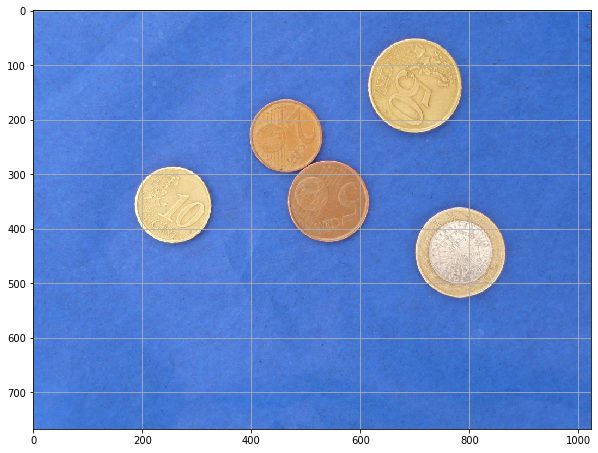

In [0]:
CoinDetector.show_image(c.image)

Uma dada imagem que, para além de moedas de euro e centimos de euro, poderá ter igualmente objectos que não deverão ser considerados

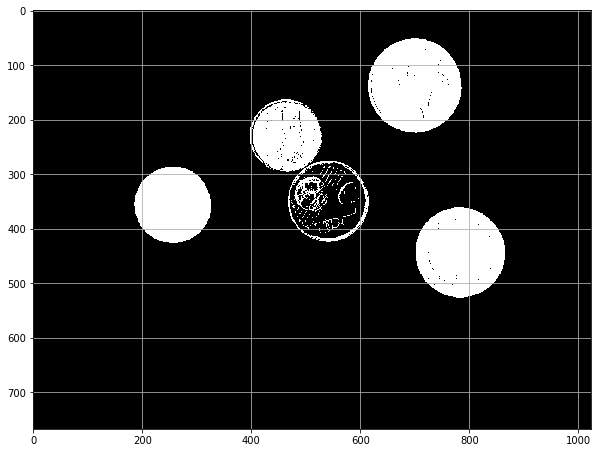

In [0]:
binaryOriginal, thresholdOriginal = CoinDetector.binary_otsu(c.image)

Imagem original binarizada recorrendo ao algortimo de ostu, algoritmo este que encontra o threshold ideal no histograma da imagem, antes de proceder à binarização


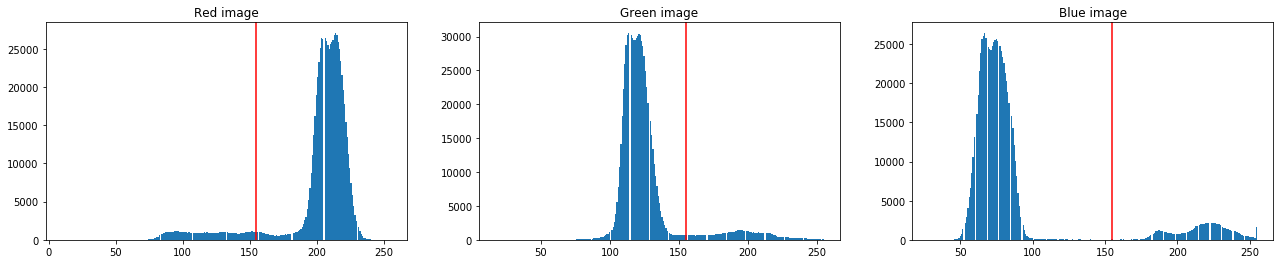

In [0]:
CoinDetector.image_histogram(c.image, thresholdOriginal)

Histograma das componentes RGB da imagem original, com o threshold calculado pela binarização de otsu

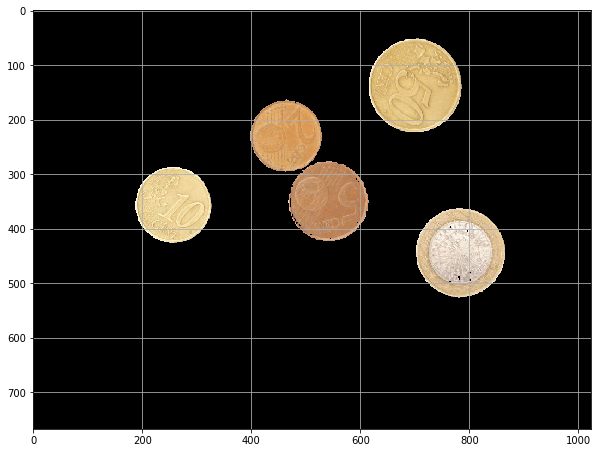

In [0]:
imageYELMak = CoinDetector.mask_color(c.image, CoinDetector.YELLOW)

Um método de refinar a binarização, é limitar a gama de cores disponível no histograma, isto de modo a que o threshold tenha uma aplicação mais eficaz antes de binarizar a imagem.

Para tal, é aplicado um filtro de cor sobre a imagem original, em que apenas são consideradas gamas de amarelos.

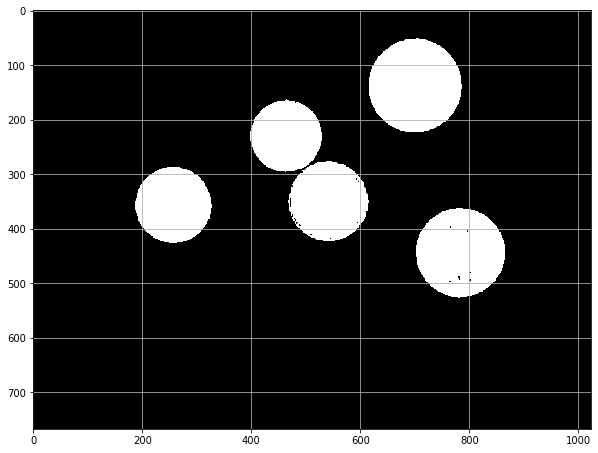

Binarização com gama de amarelos


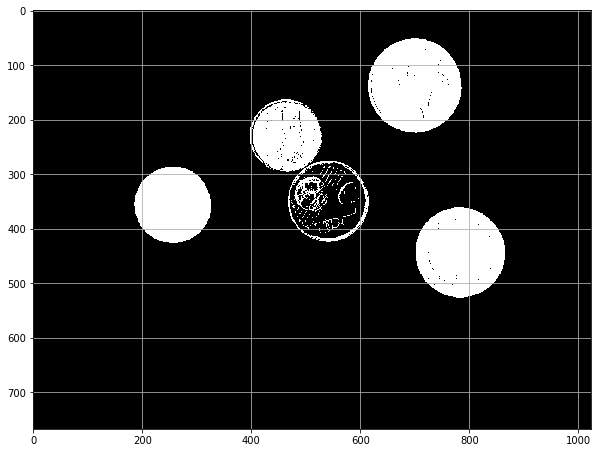

Binarização imagem original


In [0]:
binaryYELMask, thresholdYELMask = CoinDetector.binary_otsu(imageYELMak)
print('Binarização com gama de amarelos')

c.show_image(binaryOriginal)
print('Binarização imagem original')

A diferença entre aplicar a binarização de otsu à imagem original, ou primeiro aplicar o filtro de amarelos e só depois a binarização, é que no final o resultado da binarização tem menos ruído

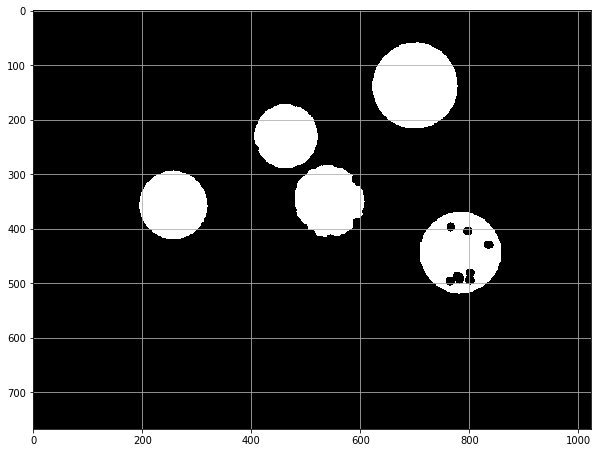

Erosão após binarização com gama de amarelos


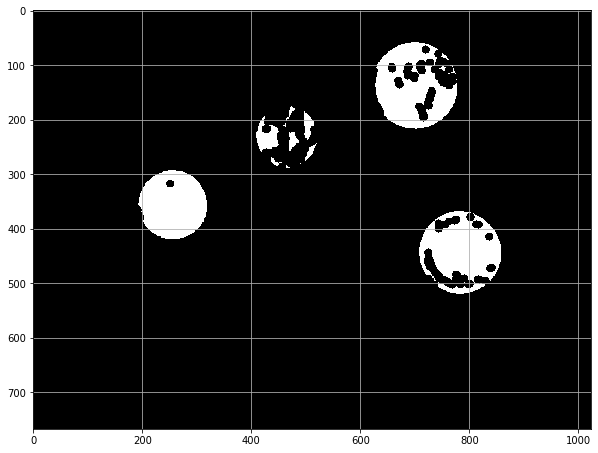

Erosão após binarização imagem original


In [0]:
erosionYELMask = CoinDetector.erose(binaryYELMask, (15,15))
print('Erosão após binarização com gama de amarelos')

erosionOriginal = CoinDetector.erose(binaryOriginal, (15,15))
print('Erosão após binarização imagem original')

É feita a erosão para separar possíveis moedas que se tocam, de modo a que o labeling identifique os objectos distíntos.
A propagação do ruído é bastante mais acentuada no caso da binarização da imagem original

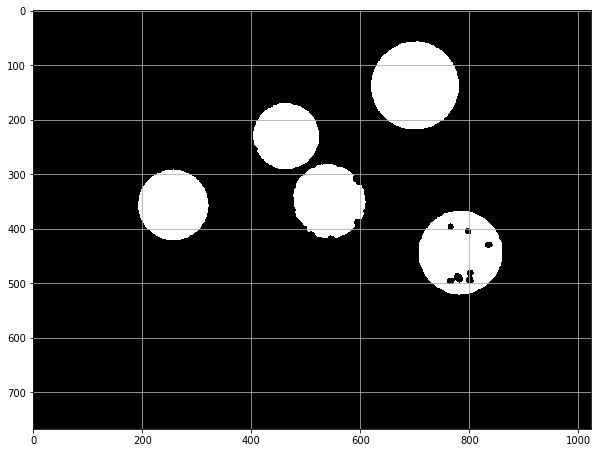

Dilatação após erosão com gama de amarelos


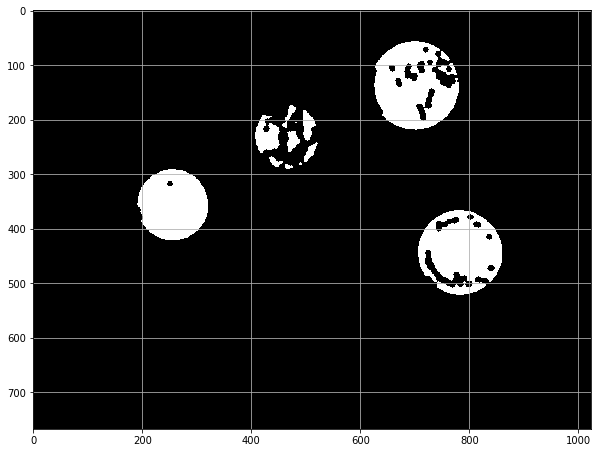

Dilatação após erosão imagem original


In [0]:
dilationYELMask = CoinDetector.dilation(erosionYELMask, (5,5))
print('Dilatação após erosão com gama de amarelos')

dilationOriginal = CoinDetector.dilation(erosionOriginal, (5,5))
print('Dilatação após erosão imagem original')

De modo a restaurar a maior área original possivel, é aplicada uma dilatação após a erosão. No entanto, e novamente, a imagem após aplicada a gama de amarela tem um desempenho superior

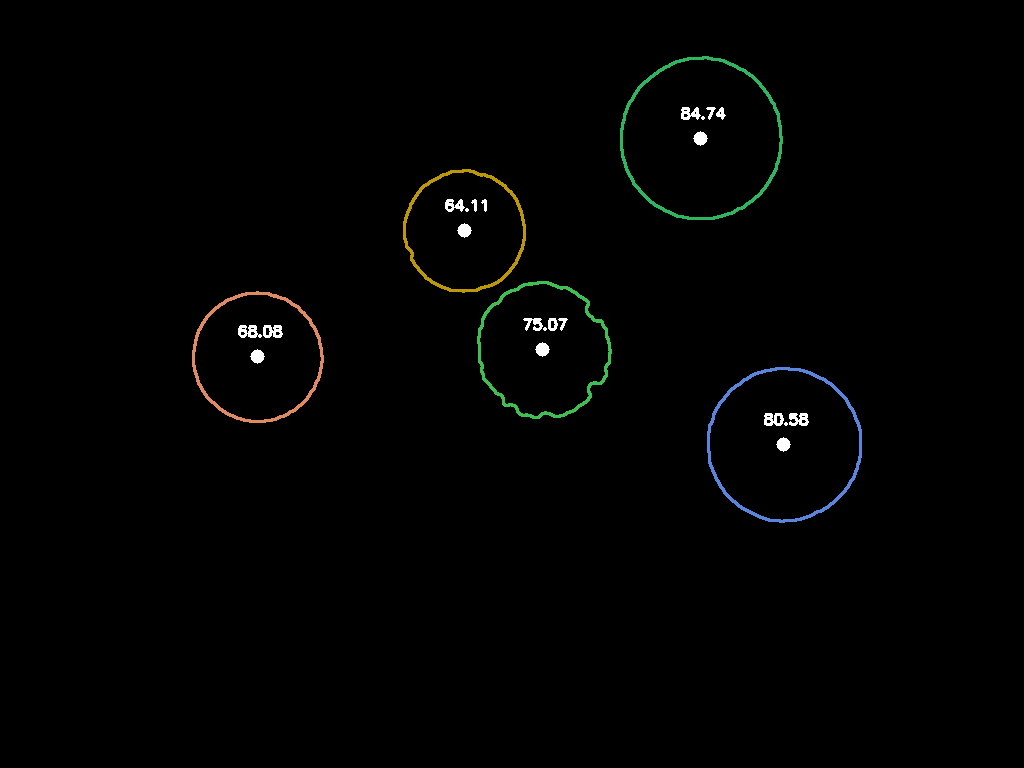

Identificação de objectos (gama de amarelos)


In [0]:
areas, perims, radius = CoinDetector.labelImage(dilationYELMask)
print('Identificação de objectos (gama de amarelos)')

Após a aplicação dos algoritmos de erosão e dilatação, estamos preparados para identificar objectos distíntos que se encontrem na imagem, e retirar as respetivas features (área, perímetro, e raio).

In [0]:
c.classify(k=5)

Matriz de features x número de moedas da imagem
[[11282.         12908.         13470.5        18210.5
  20186.5       ]
 [  402.81832218   427.78888476   471.68837869   506.31579614
    532.45793104]
 [   64.11052714    68.08471561    75.07153707    80.58266172
     84.74331171]]

K indices dos vizinhos mais proximos para cada uma das imagens
[[22  2 23  6 34]
 [18 19 29 12 25]
 [14 10 26 31  7]
 [ 9 26 10 24 21]
 [ 1 29 19 28 17]]

K classes previstas para cada uma das imagens
[[  2.  10.  10. 100.  50.]
 [  2.  10.  10. 100.  50.]
 [  2.  10.  10. 100.  50.]
 [  2.  10.  10. 100.  50.]
 [  2.  10.  10. 100.  50.]]

Classificação final de cada uma das imagens, e respetivo somatório de valor monetário
[  2.  10.  10. 100.  50.]

€ 1.72


Após identificação das features, ou caracteristicas da imagem processada, estas são aplicadas a um classificador kNN (k vizinhos mais próximos), de modo a serem cruzadas com caracteristicas de outras moedas/imagens dentro do dataset já carregado.

**CONCLUSÃO**